<a href="https://colab.research.google.com/github/raresrosca/Autoencoder/blob/master/Variational_Autoencoder_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import transforms
from torchvision.utils import save_image

import os

In [0]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5, ),(0.5, ))
])

dataset = torchvision.datasets.MNIST('/content/MNIST_data/', transform = transform, download = True )

dataloader = torch.utils.data.DataLoader(dataset, batch_size = 128, shuffle = True, num_workers = 4)



In [0]:
def to_img(x):
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

torch.Size([128, 1, 28, 28])


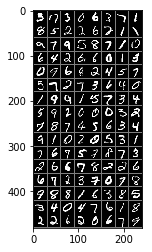

In [3]:
import matplotlib.pyplot as plt
import numpy as np

#functions to show an image

#functions to show an image

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()
  
# get some random training images
dataiter = iter(dataloader)
images, labels = dataiter.next()
print(images.shape)

#show images
imshow(torchvision.utils.make_grid(images))

In [4]:
print(labels)

tensor([3, 7, 3, 0, 6, 3, 7, 1, 8, 5, 2, 2, 6, 2, 1, 1, 9, 7, 9, 5, 8, 7, 1, 0,
        6, 4, 2, 6, 6, 0, 1, 3, 0, 9, 6, 8, 2, 4, 5, 7, 5, 7, 2, 7, 3, 6, 4, 0,
        1, 9, 9, 1, 5, 7, 3, 4, 5, 9, 2, 0, 0, 0, 3, 2, 7, 8, 7, 4, 5, 6, 3, 4,
        9, 1, 0, 2, 0, 5, 3, 1, 7, 6, 7, 5, 7, 8, 7, 3, 2, 6, 6, 7, 8, 2, 2, 6,
        6, 7, 2, 3, 7, 0, 7, 8, 9, 8, 8, 1, 6, 3, 8, 5, 3, 4, 0, 4, 7, 6, 1, 8,
        2, 2, 6, 2, 0, 6, 7, 9])


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
      
    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
      
    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))
      
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar
      
model = VAE()
if torch.cuda.is_available():
    model.cuda()



In [0]:
reconstruction_function = nn.MSELoss(reduction = 'sum')

In [0]:
def loss_function(recon_x, x, mu, logvar):
    """
    recon_x = generating images
    x = original images
    mu = latent mean
    logvar = latent log variance
    """

    BCE = reconstruction_function(recon_x, x) #mse loss
    
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [11]:
for epoch in range(20):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        if torch.cuda.is_available():
            img = img.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(img),
                len(dataloader.dataset), 100. * batch_idx / len(dataloader),
                loss.item() / len(img)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(dataloader.dataset)))
    if epoch % 10 == 0:
        save = to_img(recon_batch.cpu().data)
        save_image(save, '/content/myimages/image_{}.png'.format(epoch))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 0 [0/60000 (0%)]	Loss: 184.079666
Train Epoch: 0 [12800/60000 (21%)]	Loss: 50.201645
Train Epoch: 0 [25600/60000 (43%)]	Loss: 43.886936
Train Epoch: 0 [38400/60000 (64%)]	Loss: 39.362793
Train Epoch: 0 [51200/60000 (85%)]	Loss: 36.245567
====> Epoch: 0 Average loss: 45.5720
Train Epoch: 1 [0/60000 (0%)]	Loss: 37.163567
Train Epoch: 1 [12800/60000 (21%)]	Loss: 36.042522
Train Epoch: 1 [25600/60000 (43%)]	Loss: 33.350807
Train Epoch: 1 [38400/60000 (64%)]	Loss: 33.834087
Train Epoch: 1 [51200/60000 (85%)]	Loss: 34.540440
====> Epoch: 1 Average loss: 34.9589
Train Epoch: 2 [0/60000 (0%)]	Loss: 34.549351
Train Epoch: 2 [12800/60000 (21%)]	Loss: 33.533493
Train Epoch: 2 [25600/60000 (43%)]	Loss: 33.057610
Train Epoch: 2 [38400/60000 (64%)]	Loss: 33.082748
Train Epoch: 2 [51200/60000 (85%)]	Loss: 32.560734
====> Epoch: 2 Average loss: 33.0853
Train Epoch: 3 [0/60000 (0%)]	Loss: 32.731636
Train Epoch: 3 [12800/60000 (21%)]	Loss: 33.114998
Train Epoch: 3 [25600/60000 (43%)]	Loss: 

In [82]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
!mkdir myimages